# Section 1: Extract and Save Scholar Information

In [ ]:
import pandas as pd
from scholarly import scholarly

# List of Google Scholar IDs (Replace with actual IDs)
scholar_ids = ["hgwfis4AAAAJ", "xJH3kdEAAAAJ","hgwfis4AAAAJ","92WslkgAAAAJ","4aHf5O8AAAAJ","pqP66FLxeBMC","lCP4ZqMAAAAJ","yUB8lNsAAAAJ","c0R1WokAAAAJ","zu1MSEEAAAAJ","HMAzliEAAAAJ","0YYnNYkAAAAJ","rMH0CcAAAAJ","fWgOgcIAAAAJ"]

# Lists to store extracted data
data = []

# Step 1: Extract Data for All Professors
for scholar_id in scholar_ids:
    try:
        author = scholarly.search_author_id(scholar_id)
        author = scholarly.fill(author)

        profile_data = {
            "Scholar ID": scholar_id,
            "Name": author.get("name", "N/A"),
            "Affiliation": author.get("affiliation", "N/A"),
            "Email": author.get("email_domain", "N/A"),
            "Citations": author.get("citedby", "N/A"),
            "H-Index": author.get("hindex", "N/A"),
            "i10-Index": author.get("i10index", "N/A"),
            "Interests": ", ".join(author.get("interests", [])),
            "Profile URL": f"https://scholar.google.com/citations?user={scholar_id}"
        }
        data.append(profile_data)

    except Exception as e:
        print(f"Error retrieving data for ID {scholar_id}: {e}")

# Step 2: Store Data in CSV File
df = pd.DataFrame(data)
df.to_csv("google_scholar_profiles.csv", index=False)

print("Scholar profile data saved to 'google_scholar_profiles.csv'.")


Error retrieving data for ID xJH3kdEAAAAJ: Cannot Fetch from Google Scholar.
Error retrieving data for ID rMH0CcAAAAJ: 'NoneType' object has no attribute 'get'
Scholar profile data saved to 'google_scholar_profiles.csv'.


# Section 2: Compute Graph Measures and Save

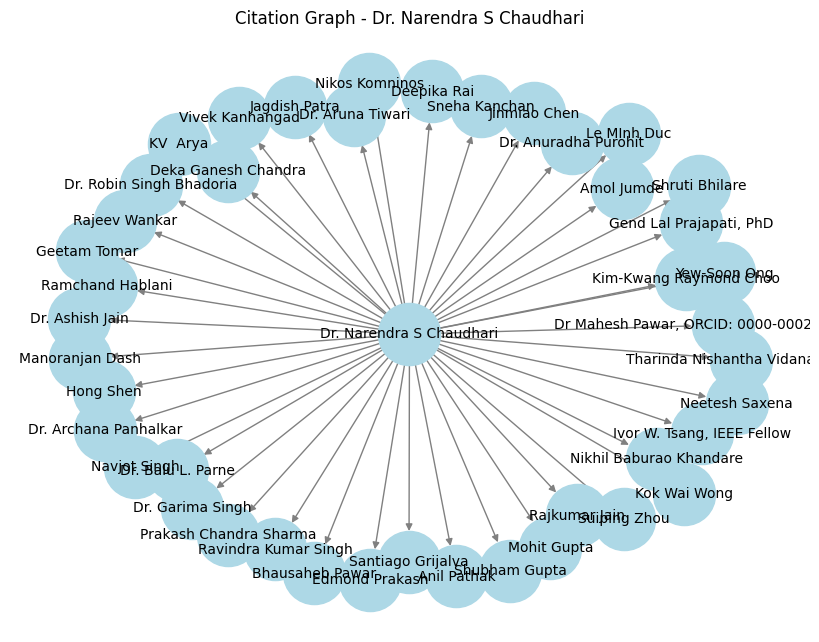

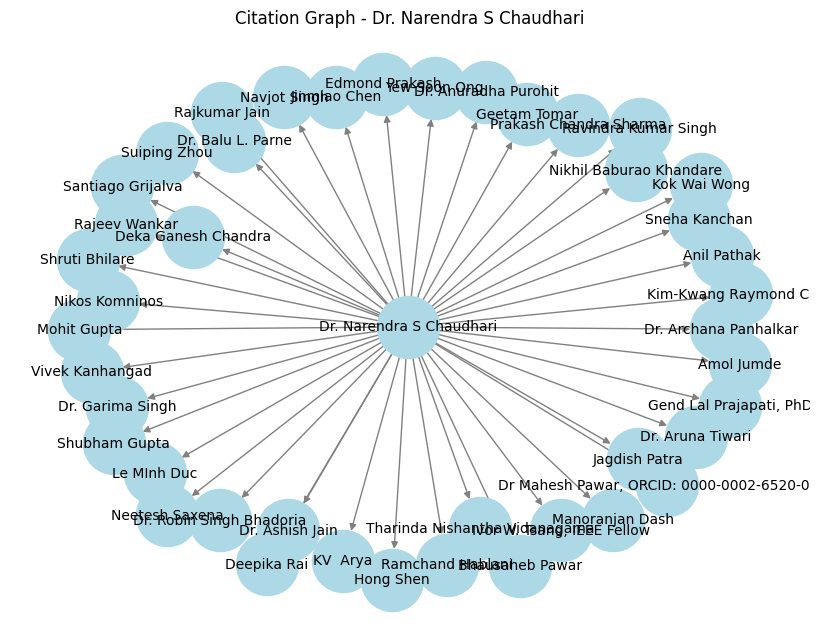

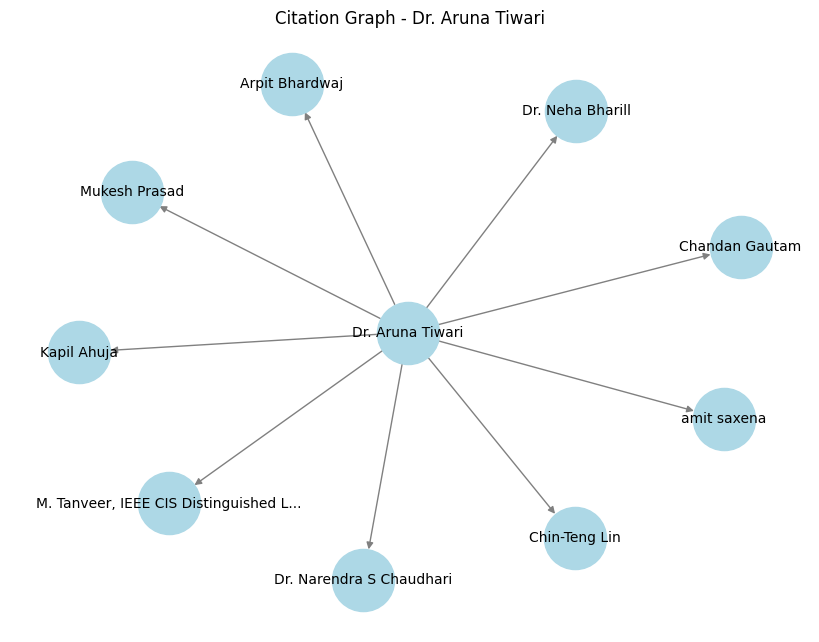

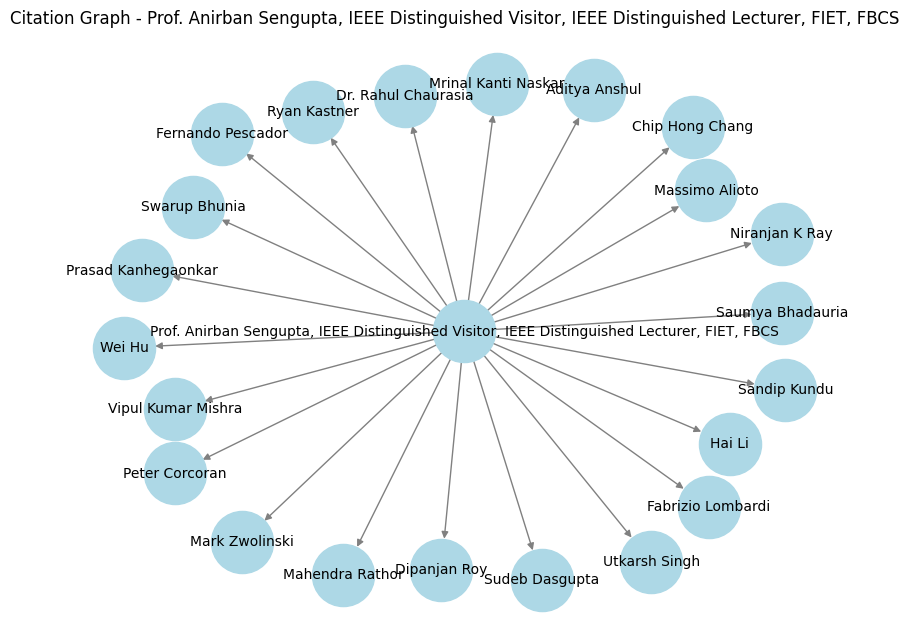

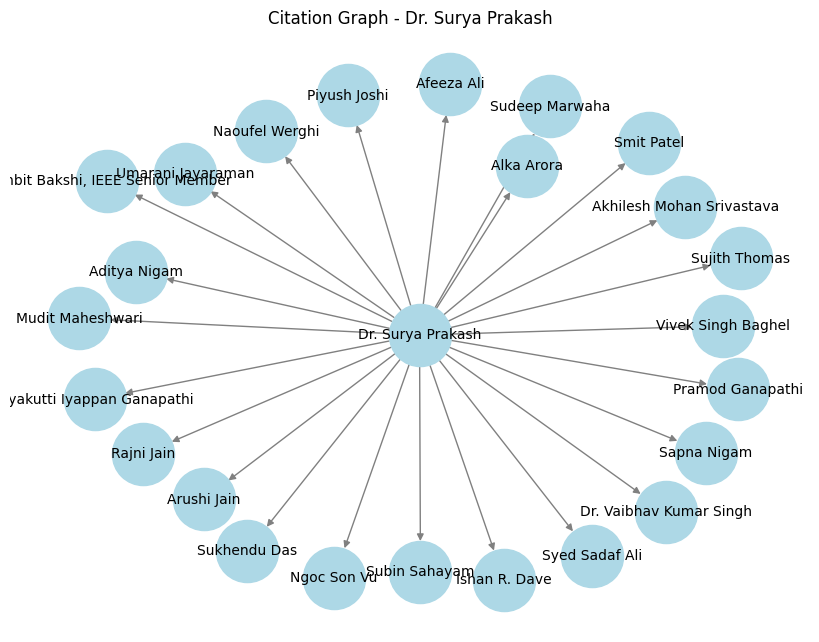

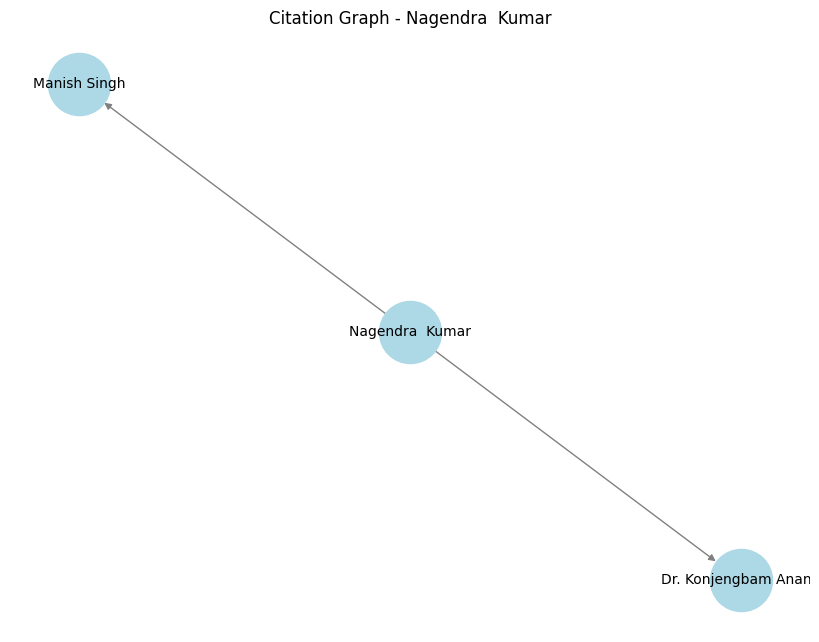

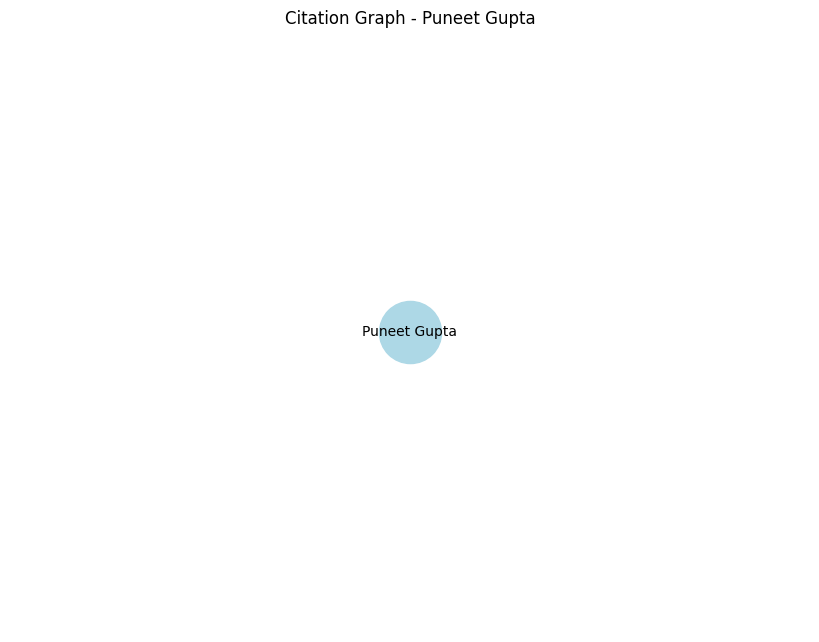

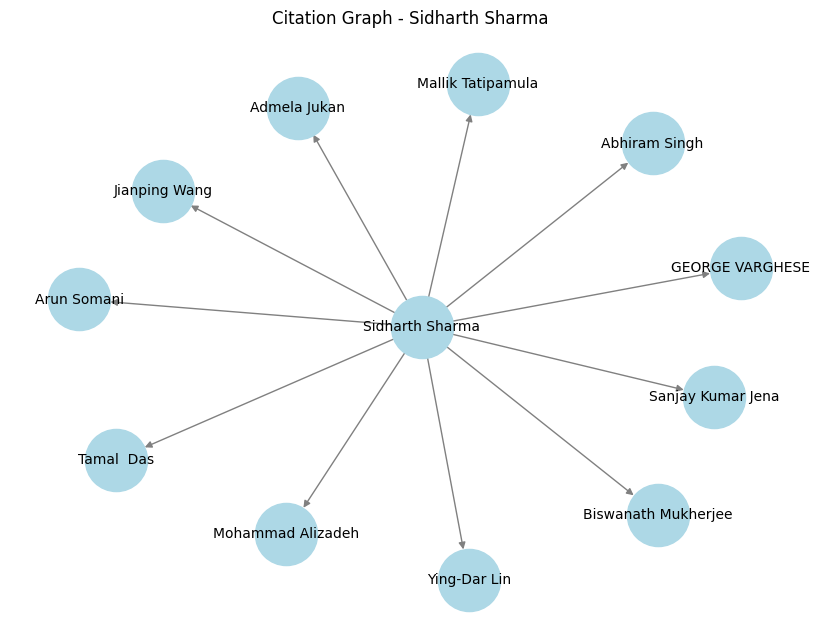

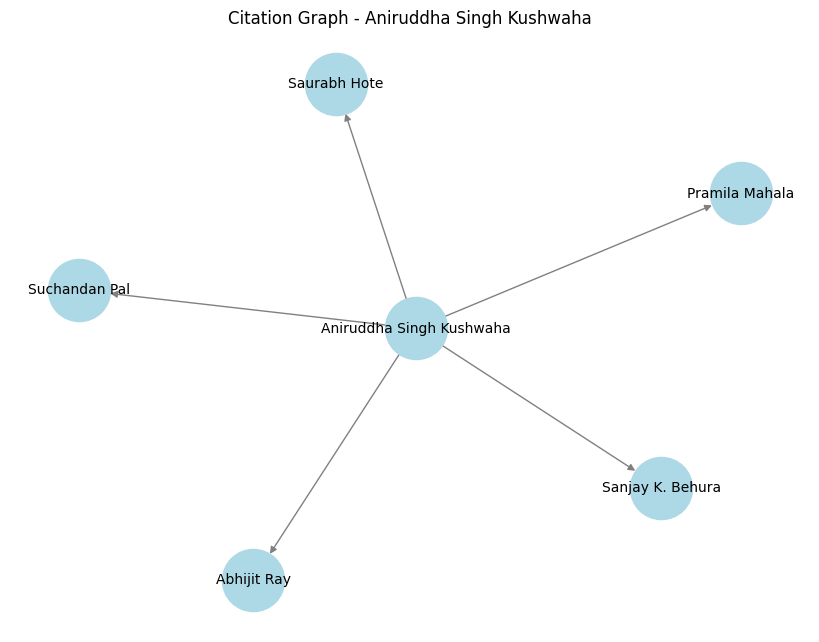

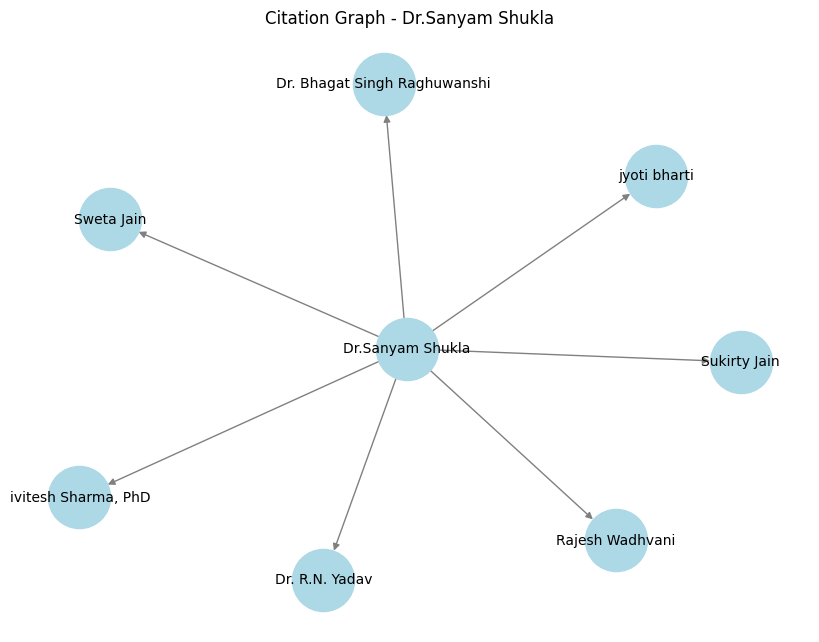

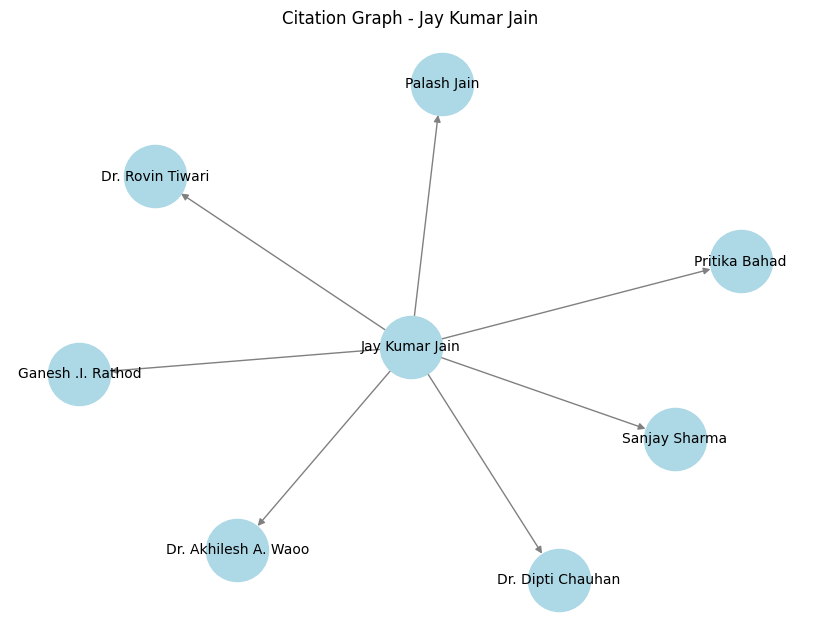

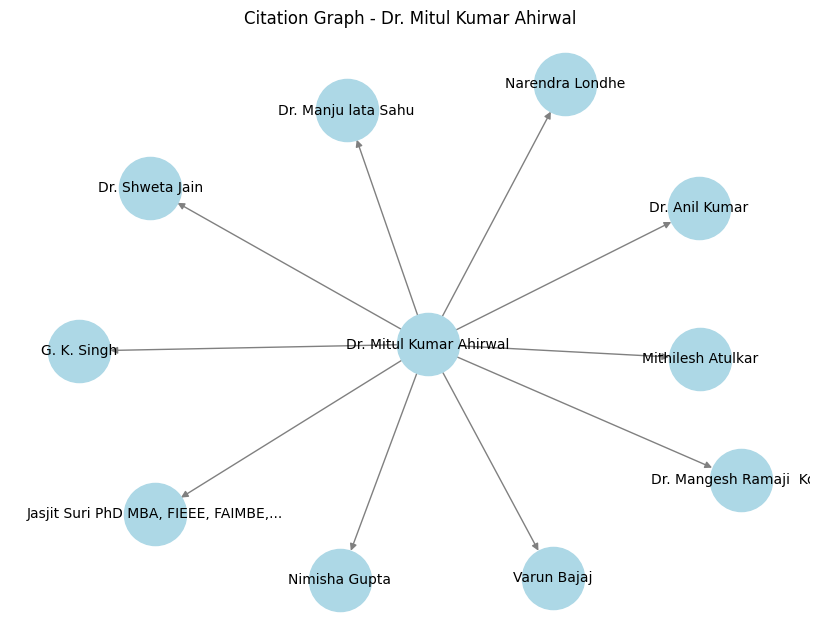

Graph analysis completed. Metrics saved to 'scholar_graph_metrics.csv'.


In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Professors from CSV
professors_df = pd.read_csv("google_scholar_profiles.csv")
scholar_ids = professors_df["Scholar ID"].tolist()
professor_names = professors_df["Name"].tolist()

graph_metrics_list = []

for i, scholar_id in enumerate(scholar_ids):
    try:
        # Get author details
        author = scholarly.search_author_id(scholar_id)
        author = scholarly.fill(author)

        professor_name = author.get("name", f"Professor {i+1}")

        # Create a Directed Graph for the professor
        G = nx.DiGraph()

        # Add professor as a node
        G.add_node(professor_name)

        # Add co-authors as nodes and edges
        for coauthor in author.get("coauthors", []):
            coauthor_name = coauthor["name"]
            G.add_node(coauthor_name)
            G.add_edge(professor_name, coauthor_name)  # Directed edge

        # Compute Graph Measures
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        closeness_centrality = nx.closeness_centrality(G) if num_nodes > 1 else {}

        avg_degree = sum(dict(G.degree()).values()) / num_nodes if num_nodes > 0 else 0
        clustering_coefficient = nx.average_clustering(G) if num_nodes > 1 else 0

        # Save metrics
        metrics = {
            "Professor": professor_name,
            "Scholar ID": scholar_id,
            "Nodes": num_nodes,
            "Edges": num_edges,
            "Density": density,
            "Avg Degree": avg_degree,
            "Clustering Coefficient": clustering_coefficient,
            "Degree Centrality": degree_centrality.get(professor_name, 0),
            "Betweenness Centrality": betweenness_centrality.get(professor_name, 0),
            "Closeness Centrality": closeness_centrality.get(professor_name, 0),
        }
        graph_metrics_list.append(metrics)

        # Print metrics
        print(metrics)

        # Visualize Graph
        plt.figure(figsize=(8, 6))
        nx.draw(G, with_labels=True, node_size=2000, node_color="lightblue", edge_color="gray", font_size=10)
        plt.title(f"Citation Graph - {professor_name}")
        plt.savefig(f"{professor_name}_citation_graph.png")
        plt.show()

    except Exception as e:
        print(f"Error processing {professor_names[i]}: {e}")

# Save Graph Metrics to CSV
metrics_df = pd.DataFrame(graph_metrics_list)
metrics_df.to_csv("scholar_graph_metrics.csv", index=False)

print("Graph analysis completed. Metrics saved to 'scholar_graph_metrics.csv'.")


# Section 3: Determine the Best Professor

In [ ]:
import pandas as pd

# Load Metrics
graph_metrics = pd.read_csv("scholar_graph_metrics.csv")

# Fill missing values with 0
graph_metrics.fillna(0, inplace=True)

# Normalize Graph Parameters Safely
for column in ["Density", "Avg Degree", "Clustering Coefficient", "Degree Centrality", "Betweenness Centrality", "Closeness Centrality"]:
    if column in graph_metrics.columns:
        col_min, col_max = graph_metrics[column].min(), graph_metrics[column].max()
        if col_max > col_min:  # Only normalize if there's a range
            graph_metrics[column] = (graph_metrics[column] - col_min) / (col_max - col_min)

# Compute Overall Score (Weighted Sum)
graph_metrics["Overall Score"] = (
    graph_metrics["Density"] * 0.1 +
    graph_metrics["Avg Degree"] * 0.2 +
    graph_metrics["Clustering Coefficient"] * 0.1 +
    graph_metrics["Degree Centrality"] * 0.2 +
    graph_metrics["Betweenness Centrality"] * 0.2 +
    graph_metrics["Closeness Centrality"] * 0.2
)

# Ensure no NaN values in "Overall Score"
graph_metrics["Overall Score"].fillna(0, inplace=True)

if not graph_metrics.empty and graph_metrics["Overall Score"].max() > 0:
    best_professor_row = graph_metrics.loc[graph_metrics["Overall Score"].idxmax()]
    best_professor = best_professor_row["Professor"]
    print("🏆 The Best Professor based on citation and graph parameters is:")
    print(f"➡️ {best_professor}")
else:
    best_professor = "No valid data available"
    print("⚠️ No valid data available to determine the best professor.")

# Save Rankings
graph_metrics.sort_values(by="Overall Score", ascending=False).to_csv("professor_rankings.csv", index=False)

print("📊 Professor rankings saved to 'professor_rankings.csv'.")


🏆 The Best Professor based on citation and graph parameters is:
➡️ Nagendra  Kumar
📊 Professor rankings saved to 'professor_rankings.csv'.


C:\Users\HP\AppData\Local\Temp\ipykernel_1312\516086231.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  graph_metrics["Overall Score"].fillna(0, inplace=True)


In [2]:
from datetime import datetime

current_year = datetime.now().year
recent_publications = []

for pub in author['publications']:
    pub = scholarly.fill(pub)
    pub_year = pub.get('bib', {}).get('pub_year')
    if pub_year and current_year - int(pub_year) <= 3:
        recent_publications.append(pub)

# Display recent publications
for pub in recent_publications:
    print(f"Title: {pub['bib']['title']}")
    print(f"Year: {pub['bib']['pub_year']}")
    print(f"Citations: {pub.get('num_citations', 0)}")
    print(f"URL: {pub['pub_url']}")
    print("-" * 40)


Title: RETRACTED ARTICLE: Fingerprint classification system using CNN
Year: 2022
Citations: 14
URL: https://link.springer.com/article/10.1007/s11042-022-12294-4
----------------------------------------
Title: SEAI: secrecy and efficiency aware inter-gNB handover authentication and key agreement protocol in 5G communication network
Year: 2022
Citations: 13
URL: https://link.springer.com/article/10.1007/s11277-021-09036-4
----------------------------------------
Title: SPSR-VCP: secure and privacy preserving SignRecryption in vehicular cyber physical systems
Year: 2022
Citations: 10
URL: https://link.springer.com/article/10.1007/s12652-020-02859-2
----------------------------------------
Title: LS-AKA: A lightweight and secure authentication and key agreement scheme for enhanced machine type communication devices in 5G smart environment
Year: 2023
Citations: 3
URL: https://www.sciencedirect.com/science/article/pii/S2213138823004411
----------------------------------------
Title: SAFE: Se

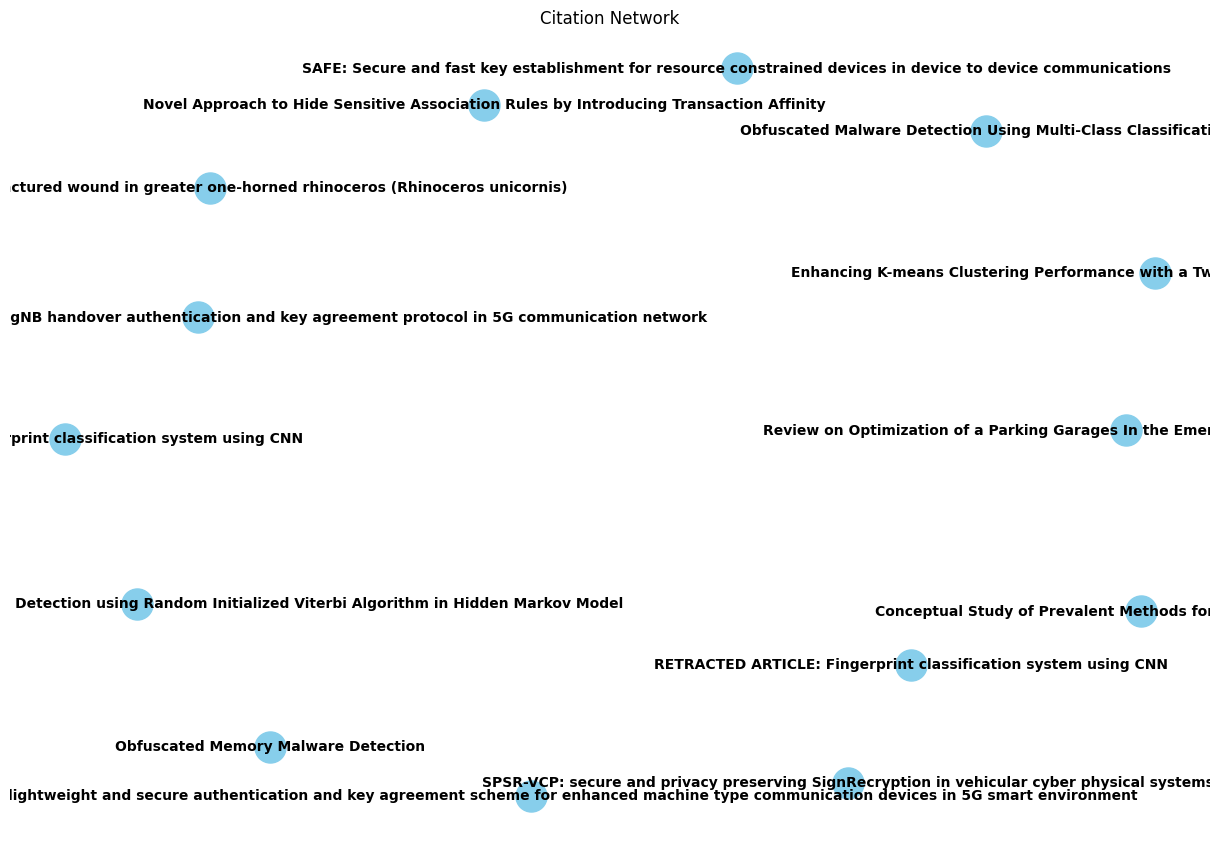

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes and edges based on citation data
for pub in recent_publications:
    G.add_node(pub['bib']['title'])
    for citation in pub.get('citations', []):
        G.add_edge(citation['title'], pub['bib']['title'])

# Compute centrality measures
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Plot the citation network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray', font_size=10, font_weight='bold')
plt.title('Citation Network')
plt.show()
